In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ridgepy.libridgewrapper.config import MAIN_CONFIG
from ridgepy.libridgewrapper.kalman_filter_mode import KalmanFilterMode
from ridgepy.libridgewrapper.kalman_filter_network import KalmanFilterNetwork

In [2]:
# This example processes the single_mode_example file created by the
# bin/simulate/0.0-simulate-single-mode.py file.
data       = np.loadtxt("single_mode_example.txt")
data_count = len(data)

Text(0.5, 0, 'time [seconds]')

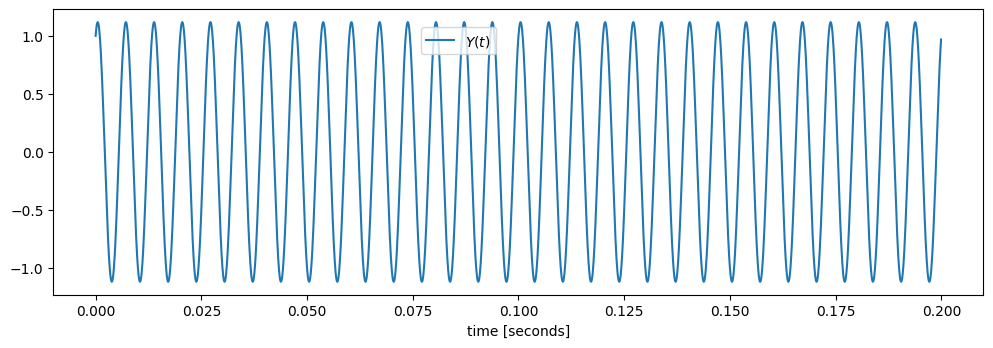

In [3]:
width  = 12.0
height = width / 1.618 / 2.

fig, ax  = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False, figsize=(width, height))
ax.plot(data[:,0], data[:,2], linestyle='-', label=r'$Y(t)$')
fig.legend(ncol=1, bbox_to_anchor=(0.5, 0.85))
ax.set_xlabel('time [seconds]')

In [4]:
# The C library is compiled for a specific number of modes. For this example
# file the library should be compiled for 6 modes
MODE_COUNT = MAIN_CONFIG['MODE_COUNT']
mode_numbers = [m for m in range(1, MODE_COUNT + 1)]
assert MODE_COUNT == 6, f"MODE_COUNT is {MODE_COUNT}. Recompile the C library for MODE_COUNT = 6"

In [5]:

# We assume knowledge of the frequency of the single, but no knowledge of the
# phase or the coefficients.
FREQUENCY  = 50.0
PHASE      = 0.0
COEFFICIENTS = np.zeros((MODE_COUNT,2))

In [6]:
# The audio signal is sampled at 16kHz. We want to make the mode parameters
# dimensionless to avoid numerical issues in the code.
frequency_sample = 16000.0
time_delta = 1./frequency_sample
dimensionless_mode_parameter = 2*np.pi*time_delta*FREQUENCY

In [43]:
kf_network = KalmanFilterNetwork(
    mode_numbers,
    1.0,
    COEFFICIENTS,
    [
        [0.0001, 0.0],
        [0.0, 0.0001],
    ],
    2.0
)

In [44]:
estimate     = np.zeros((len(data), 1))
error        = np.zeros((len(data), 1))
convergence  = np.zeros((len(data), MODE_COUNT))
predictions  = np.zeros((len(data), MODE_COUNT))
phase        = np.zeros((len(data), 1))
frequency    = np.zeros((len(data), 1))
gain         = np.zeros((len(data), MODE_COUNT, 2))
coefficients = np.zeros((len(data), MODE_COUNT, 2))
power        = np.zeros((MODE_COUNT, len(data)))

In [45]:
for ndx, row in enumerate(data):
    observation = row[2]

    # Evolve the state and handle initial conditions
    if ndx == 0:
        frequency[ndx] = FREQUENCY
        phase[ndx]     = PHASE
    elif ndx > 0:
        frequency[ndx]  = frequency[ndx-1]
        phase[ndx]      = phase[ndx-1]
        phase[ndx]     += dimensionless_mode_parameter

    phase[ndx] = np.mod(phase[ndx], 2*np.pi)

    ## Update the prior
    kf_network.prior_update(phase[ndx], observation)

    estimate[ndx,0] = kf_network.prediction
    error[ndx,0]    = kf_network.error
    for mode_ndx in range(MODE_COUNT):
        convergence[ndx, mode_ndx] = kf_network.kf_modes[mode_ndx].convergence
        predictions[ndx, mode_ndx] = kf_network.kf_modes[mode_ndx].prediction

    ## Update the posterior
    kf_network.posterior_update()

    for mode_ndx in range(MODE_COUNT):
        coefficients[ndx, mode_ndx, 0] = kf_network.kf_modes[mode_ndx].coefficients[0]
        coefficients[ndx, mode_ndx, 1] = kf_network.kf_modes[mode_ndx].coefficients[1]
        gain[ndx, mode_ndx, 0] = kf_network.kf_modes[mode_ndx].gain[0]
        gain[ndx, mode_ndx, 1] = kf_network.kf_modes[mode_ndx].gain[1]
        power[mode_ndx, ndx] = np.sqrt(
            kf_network.kf_modes[mode_ndx].coefficients[0]**2 +
            kf_network.kf_modes[mode_ndx].coefficients[1]**2
        )

In [46]:
width  = 12.0
height = width / 1.618 / 2.

Text(0.5, 0, 'time [seconds]')

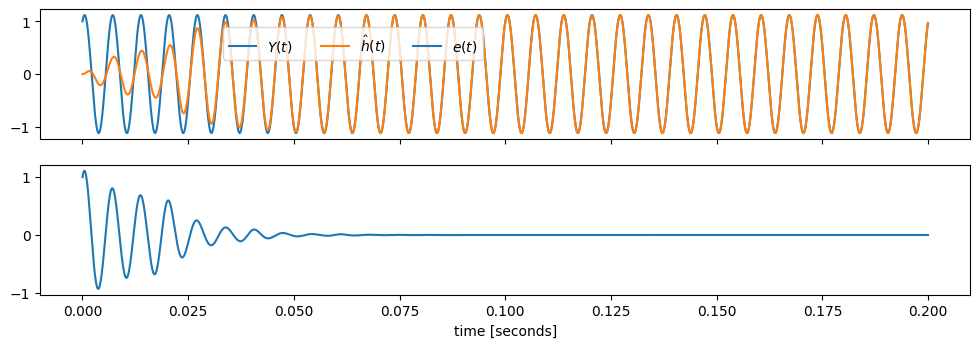

In [47]:
fig, ax  = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(width, height))
ax[0].plot(data[:,0], data[:,2], linestyle='-', label=r'$Y(t)$')
ax[0].plot(data[:,0], estimate[:,0], linestyle='-', label=r'$\hat{h}(t)$')
ax[1].plot(data[:,0], error[:,0], linestyle='-', label=r'$e(t)$')
fig.legend(ncol=3, bbox_to_anchor=(0.5, 0.85))
ax[1].set_xlabel('time [seconds]')

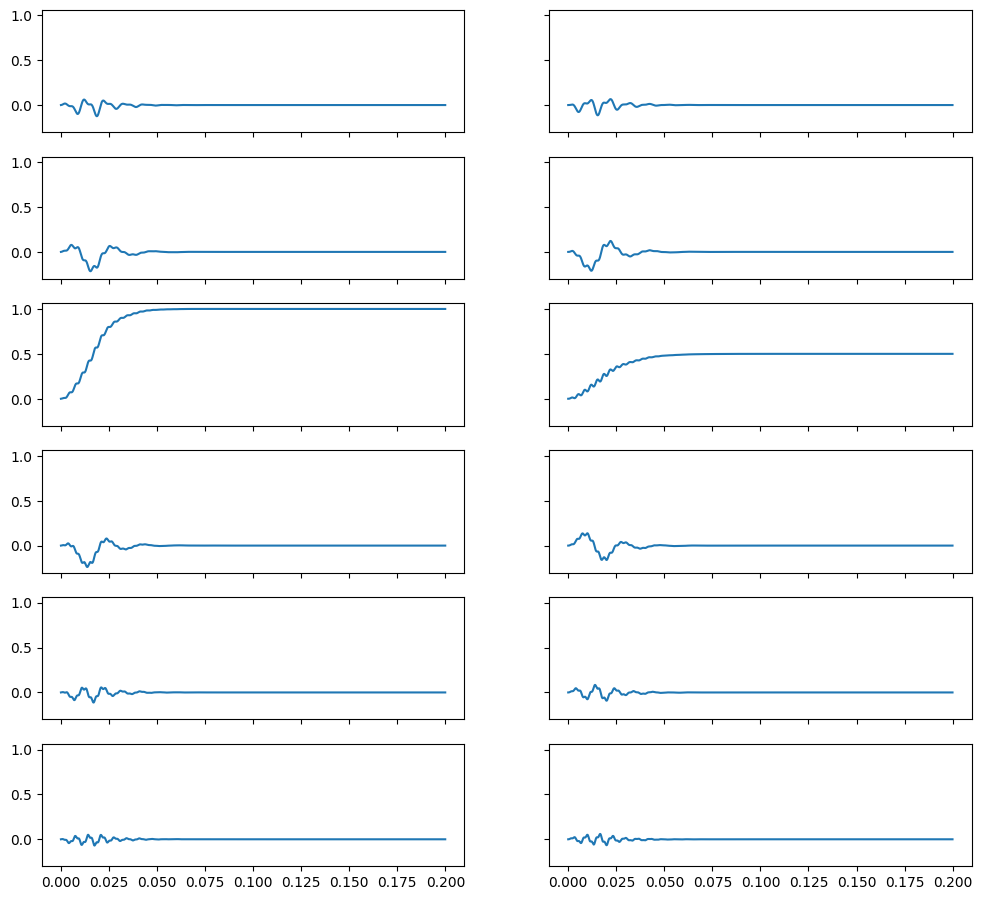

In [48]:
fig, ax  = plt.subplots(nrows=MODE_COUNT, ncols=2, sharex=True, sharey=True, figsize=(width, 3*height))
for mode_ndx in range(MODE_COUNT):
    ax[mode_ndx,0].plot(data[:,0], coefficients[:,mode_ndx, 0], linestyle='-', label=r'$\hat{A}^k(t)$')
    ax[mode_ndx,1].plot(data[:,0], coefficients[:,mode_ndx, 1], linestyle='-', label=r'$\hat{B}^k(t)$')

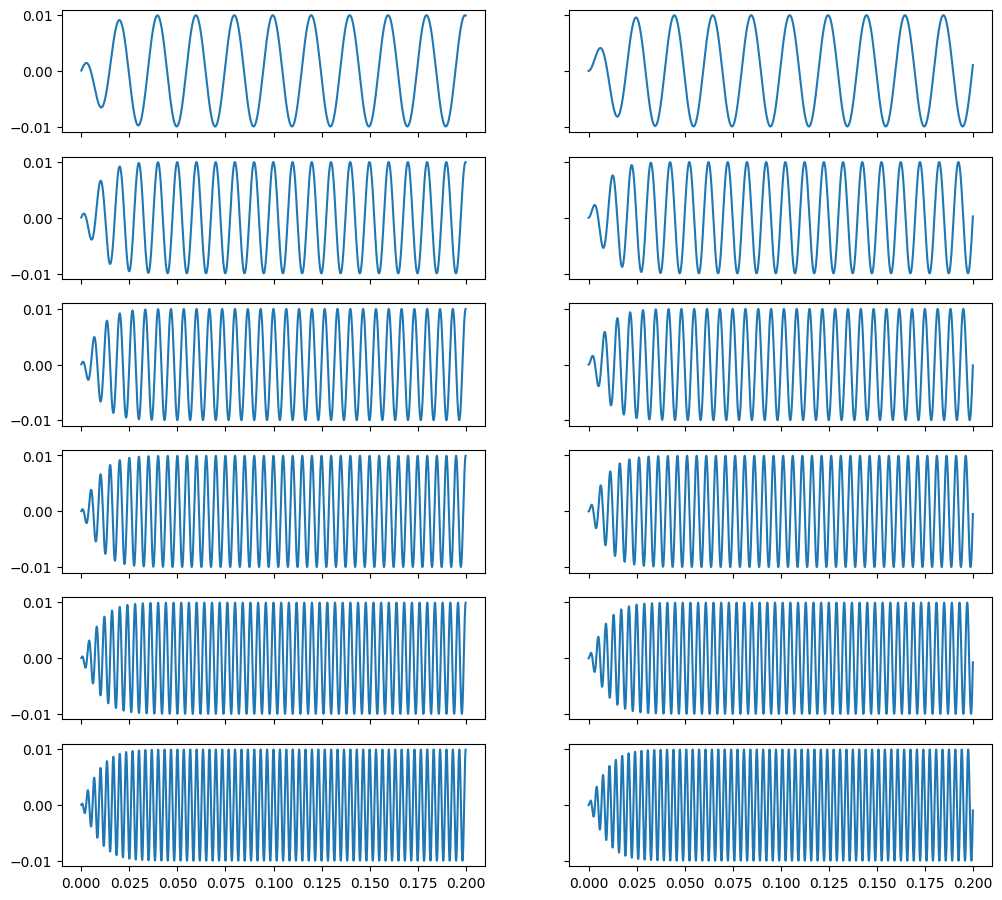

In [49]:
fig, ax  = plt.subplots(nrows=MODE_COUNT, ncols=2, sharex=True, sharey=True, figsize=(width, 3*height))
for mode_ndx in range(MODE_COUNT):
    ax[mode_ndx,0].plot(data[:,0], gain[:, mode_ndx, 0], linestyle='-', label=r'${v}^k(t)$')
    ax[mode_ndx,1].plot(data[:,0], gain[:, mode_ndx, 1], linestyle='-', label=r'${v}^k(t)$')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'time [seconds]')

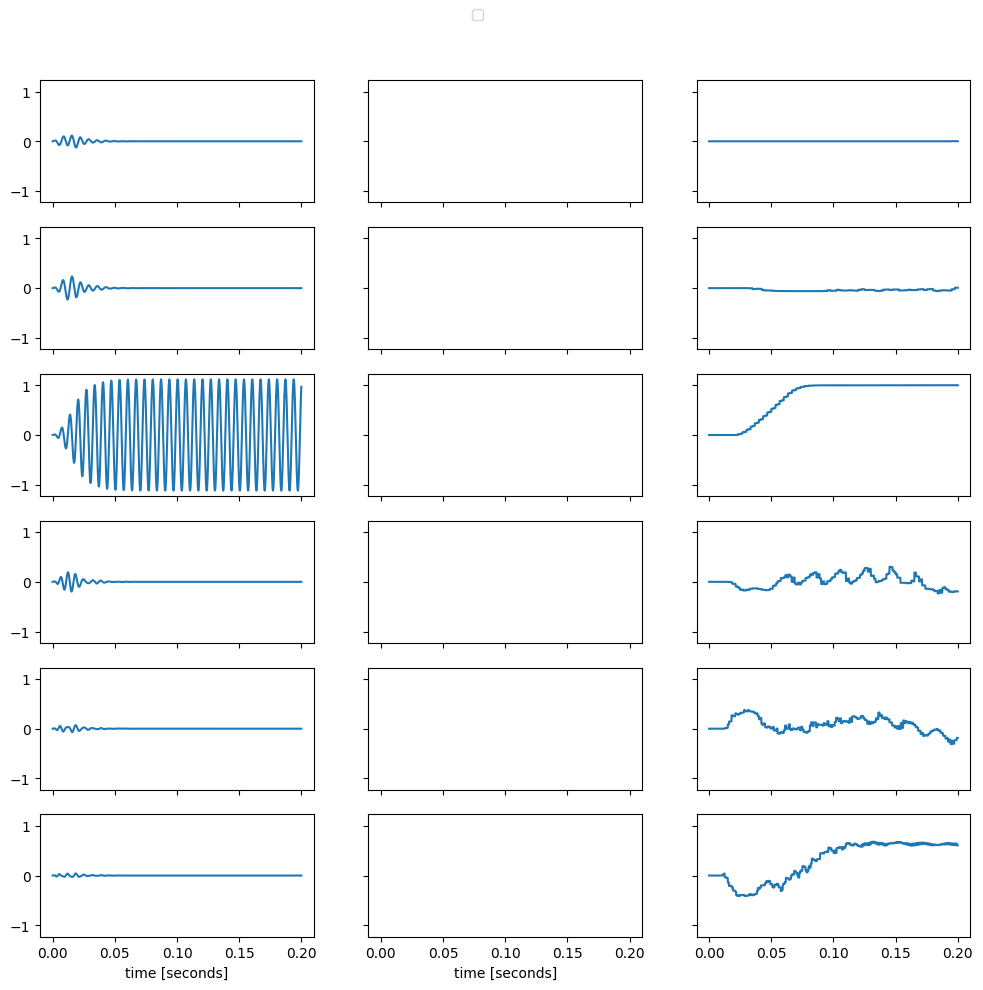

In [50]:
fig, ax  = plt.subplots(nrows=MODE_COUNT, ncols=3, sharex=True, sharey=True, figsize=(width, 3*height))
for mode_ndx in range(MODE_COUNT):
    ax[mode_ndx,0].plot(data[:,0], predictions[:,mode_ndx], linestyle='-')
    ax[mode_ndx,2].plot(data[:,0], convergence[:,mode_ndx], linestyle='-')
fig.legend(ncol=3, bbox_to_anchor=(0.5, 0.95))
ax[-1, 0].set_xlabel('time [seconds]')
ax[-1, 1].set_xlabel('time [seconds]')

(0.0, 1200.0)

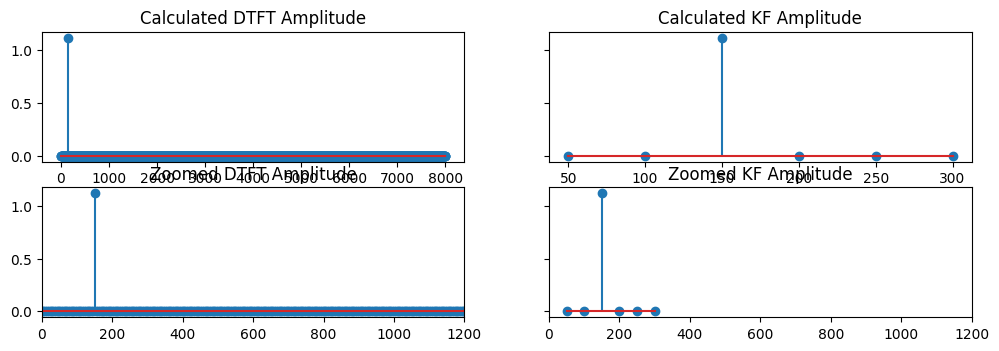

In [51]:
fig, ax  = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=True, figsize=(width, height))
fft = np.fft.rfft(data[:,2])
freq = np.fft.rfftfreq(data_count, d=time_delta)
ax[0, 0].set_title("Calculated DTFT Amplitude")
ax[0, 0].stem(freq, 2.0/data_count * np.abs(fft))
ax[0, 1].set_title("Calculated KF Amplitude")
ax[0, 1].stem(frequency[-1] * np.array(mode_numbers), power[:,-1])

ax[1, 0].set_title("Zoomed DTFT Amplitude")
ax[1, 0].stem(freq, 2.0/data_count * np.abs(fft))
ax[1, 0].set_xlim([0, 1200])
ax[1, 1].set_title("Zoomed KF Amplitude")
ax[1, 1].stem(frequency[-1] * np.array(mode_numbers), power[:,-1])
ax[1, 1].set_xlim([0, 1200])